In [1]:
from datetime import datetime
print("This notebook is to test and demonstrate the spectral line fitting and file IO.\n"
	  "This version started 120324, last automatic datestamp:",datetime.now())

This notebook is to test and demonstrate the spectral line fitting and file IO.
This version started 120324, last automatic datestamp: 2024-12-17 18:22:08.701240


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import importlib, time, copy, os, sys, numpy as np, astropy.units as u
np.set_printoptions(linewidth=160)

from astropy.io import fits; import matplotlib.pyplot as plt; from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 20,'figure.figsize':[15,10],'image.origin':'lower'}) # Make the fonts big enough for papers

base_path = '../'
sys.path.append(base_path+'linefit_modules/')
from util import get_mask_errs, get_spice_err
from skew_correction import skew_correct, deskew_linefit_window
from skew_parameter_search import search_shifts_mp, shift_holder
from linefit_leastsquares import lsq_fitter
from linefit_storage import linefits

fitter = lsq_fitter

/tmp/ipykernel_1921643/2737222420.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
linelist = {'Ar VIII+S III 700':700.3, 'O III 703':702.9, 'O III 704':703.9, 'Mg IX 706':706.0,
			'O II 718':718.5, 'S IV 745':744.9, 'S IV 748':748.4, 'S IV 750':750.2,
			'O V 759':758.7, 'S IV+O V 759':759.4, 'O V 760':760.3, 'O V 762':762.0,
			'N IV 765':765.1, 'Ne VIII 770':770.4, 'Mg VIII 772':772.3, 'Ne VIII 780':780.3,
			'S V 786':786.5, 'O IV 787':787.7, 'O IV 790':790.1, 'Ly Gamma 972':972.5,
			'C III 977':977.0, 'O I +- Na VI 989':988.7, 'N III 990':989.8, 'N III 992':991.6,
			'H I (+ O I) 1025':1025.7, 'O I 1027':1027.4, 'O VI 1032':1031.9, 'C II 1036':1036.5,
			'O VI 1037':1037.6}

line_names = list(linelist.keys())
line_waves = [linelist[name] for name in line_names]

In [4]:
spice_data_dir = '/home/jplowman/research/solar-physics/data/spice/20220307/' # Will need to update this to location of data file
spice_L2_filename = 'solo_L2_spice-n-ras_20220307T030536_V22_100663723-000.fits'
spice_L2_fullname = os.path.join(spice_data_dir, spice_L2_filename)
win_name = 'Ly Gamma 972 - Peak'

hdul = fits.open(spice_L2_fullname)
hdul.info()
spice_dat, spice_hdr = hdul[win_name].data[0], hdul[win_name].header
spice_dat = spice_dat.transpose([2,1,0]).astype(np.float32)
hdul.close()

# Manually estimated parameters of skew correction:
xlshift, ylshift = 1.6626831549412866, -1.7115244726176873

# Initial search pattern. Avoid checking 0 shift in either direction because that results in a
# sharper image and therefore more variance:
xs_quad1, ys_quad1 = np.array(np.meshgrid([-5.0,-3.0,-1.0],[-5.0,-3.0,-1.0])).transpose([0,2,1])
xs_quad2, ys_quad2 = np.array(np.meshgrid([ 1.0, 3.0, 5.0],[-5.0,-3.0,-1.0])).transpose([0,2,1])
xs_quad3, ys_quad3 = np.array(np.meshgrid([ 1.0, 3.0, 5.0],[ 1.0, 3.0, 5.0])).transpose([0,2,1])
xs_quad4, ys_quad4 = np.array(np.meshgrid([-5.0,-3.0,-1.0],[ 1.0, 3.0, 5.0])).transpose([0,2,1])

Filename: /home/jplowman/research/solar-physics/data/spice/20220307/solo_L2_spice-n-ras_20220307T030536_V22_100663723-000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Mg IX 706 - Peak    1 PrimaryHDU     418   (128, 834, 50, 1)   float32   
  1  O II 718 - Peak    1 ImageHDU       417   (128, 834, 50, 1)   float32   
  2  Ne VIII 770 / Mg VIII 772 (Merged)    1 ImageHDU       424   (128, 834, 66, 1)   float32   
  3  S V 786 / O IV 787 - Extend    1 ImageHDU       426   (128, 834, 58, 1)   float32   
  4  Ly Gamma 972 - Peak    1 ImageHDU       417   (128, 834, 36, 1)   float32   
  5  C III 977 (Merged)    1 ImageHDU       426   (128, 834, 42, 1)   float32   
  6  O VI 1032 - Peak    1 ImageHDU       417   (128, 834, 34, 1)   float32   
  7  VARIABLE_KEYWORDS    1 BinTableHDU    398   1R x 28C   [128D, 128I, 128I, 128I, 128I, 128I, 128E, 128E, 128E, 128E, 4I, 4I, 4I, 4I, 4J, 4J, 4J, 4J, 2944A, 128D, 128D, 50D, 50D, 66D, 58D, 36D, 42D, 34D]   
  8  WCSDVARR  

In [5]:
shift_vars = shift_holder(spice_dat, spice_hdr, line_waves, line_names, fitter.__name__)

In [7]:
shift_vars = search_shifts_mp(spice_dat, spice_hdr, xs_quad1, ys_quad1, line_waves, line_names, fitter, shift_vars=shift_vars)

In [8]:
shift_vars = search_shifts_mp(spice_dat, spice_hdr, xs_quad2, ys_quad2, line_waves, line_names, fitter, shift_vars=shift_vars)

In [9]:
shift_vars = search_shifts_mp(spice_dat, spice_hdr, xs_quad3, ys_quad3, line_waves, line_names, fitter, shift_vars=shift_vars)

In [10]:
shift_vars = search_shifts_mp(spice_dat, spice_hdr, xs_quad4, ys_quad4, line_waves, line_names, fitter, shift_vars=shift_vars)

In [23]:
shift_vars.save()

In [11]:
shift_vars2 = shift_holder(spice_dat, spice_hdr, line_waves, line_names, fitter.__name__)
shift_vars2.load()

In [12]:
shift_vars2.valdict

{'-5000,-5000': (-5.0, -5.0, 0.6953874305430122),
 '-5000,-3000': (-5.0, -3.0, 0.6884616491040543),
 '-5000,-1000': (-5.0, -1.0, 0.6830267545914536),
 '-3000,-5000': (-3.0, -5.0, 0.6737304789711434),
 '-3000,-3000': (-3.0, -3.0, 0.6615479249955852),
 '-3000,-1000': (-3.0, -1.0, 0.6604769317018947),
 '-1000,-5000': (-1.0, -5.0, 0.6570628765951705),
 '-1000,-3000': (-1.0, -3.0, 0.6472753633190554),
 '-1000,-1000': (-1.0, -1.0, 0.6559413933049064),
 '1000,-5000': (1.0, -5.0, 0.6540515901012517),
 '1000,-3000': (1.0, -3.0, 0.6432491048168912),
 '1000,-1000': (1.0, -1.0, 0.6505761910938521),
 '3000,-5000': (3.0, -5.0, 0.6615749532278565),
 '3000,-3000': (3.0, -3.0, 0.6502007980985309),
 '3000,-1000': (3.0, -1.0, 0.6450667105660188),
 '5000,-5000': (5.0, -5.0, 0.684467720422838),
 '5000,-3000': (5.0, -3.0, 0.6759410608016835),
 '5000,-1000': (5.0, -1.0, 0.6688441979255672),
 '1000,1000': (1.0, 1.0, 0.6600993527323578),
 '1000,3000': (1.0, 3.0, 0.6648010445714657),
 '1000,5000': (1.0, 5.0, 0.

In [14]:
# Reinterpolate the search results to a finer linear grid for ease of plotting:
from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator as lndi

xya = np.array(list(shift_vars2.valdict.values()))[:,0:2]
xa0,ya0 = np.array(np.meshgrid(np.linspace(-5,5,21),np.linspace(-5,5,21))).transpose([0,2,1])
dat = np.array(list(shift_vars2.valdict.values()))[:,2]
dat_interp = lndi(xya, dat)(xa0,ya0)

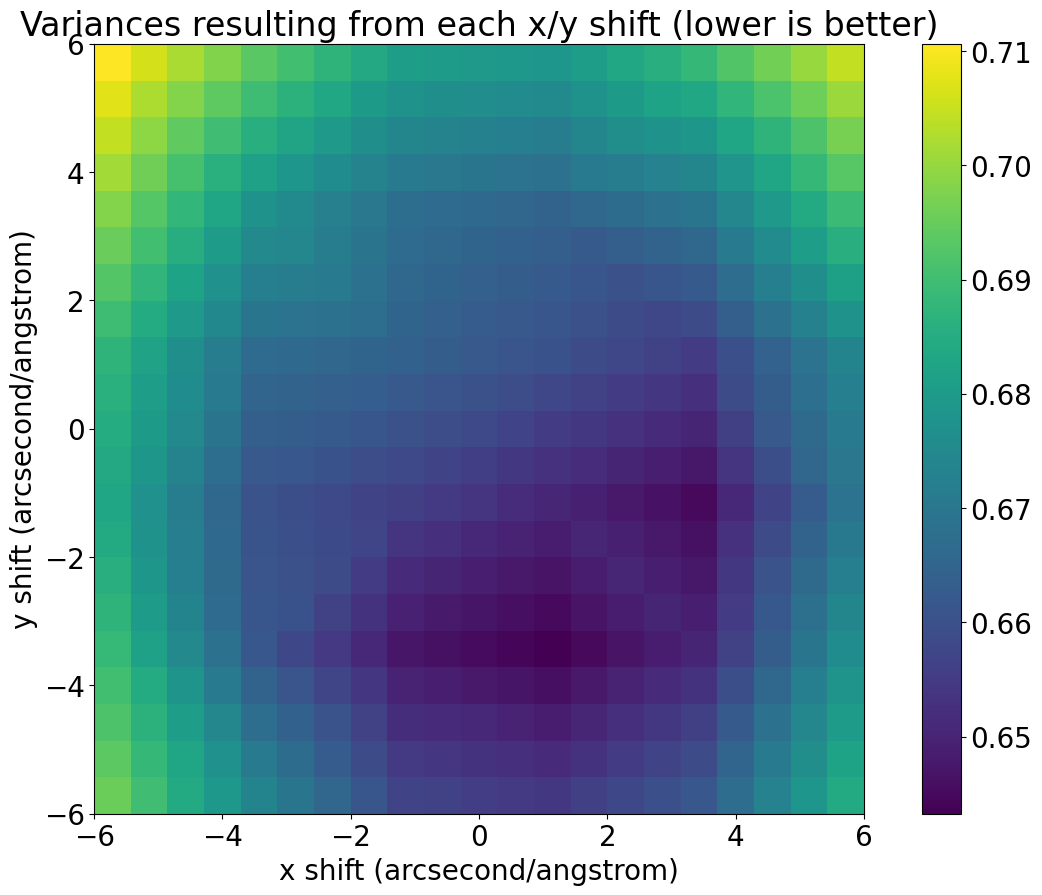

In [15]:
plt.imshow(dat_interp.T, extent=[-6,6,-6,6])
plt.title('Variances resulting from each x/y shift (lower is better)')
plt.xlabel('x shift (arcsecond/angstrom)')
plt.ylabel('y shift (arcsecond/angstrom)')
plt.colorbar()

In [16]:
# Doing a refined search narrowed in on the best values is left as an exercise to the reader...